In [1]:
import numpy as np
import ot
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from sklearn.metrics import pairwise_distances

%load_ext autoreload
%autoreload 2

In [2]:
%load_ext Cython

In [3]:
np.random.seed(31)
eps = 1e-3
N_SOURCE = 100
N_TARGET = 100

sparse = 300
sparse_idx_source = np.random.randint(N_SOURCE, size=sparse)
sparse_idx_target = np.random.randint(N_TARGET, size=sparse)

a, b = 5*np.random.random(size=N_SOURCE) , 5*np.random.random(size=N_TARGET)
#a[sparse_idx_source] = 0
#b[sparse_idx_target] = 0
a /= a.sum()
b /= b.sum()
c = pairwise_distances(np.arange(N_SOURCE).reshape(-1, 1), np.arange(N_TARGET).reshape(-1, 1))
c = np.random.random(size=(N_SOURCE, N_TARGET))
#c = c/(10*c.max())

In [4]:
pi_sink = ot.sinkhorn(a, b, c, eps)

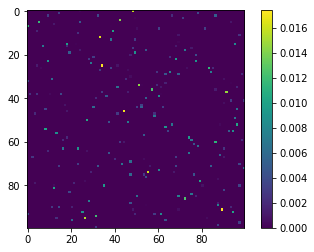

In [5]:
plt.imshow(pi_sink)
plt.colorbar()

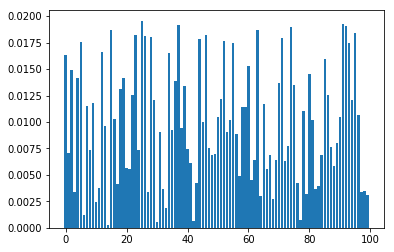

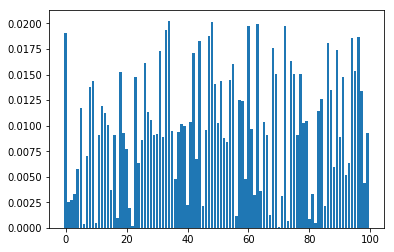

In [6]:
plt.figure()
plt.bar(np.arange(N_SOURCE), a)
plt.show()
plt.figure()
plt.bar(np.arange(N_TARGET), b)
plt.show()

In [7]:
def sinkhorn(a, b, c, eps, n_iter, return_iterates=False, tol=1e-3, max_iter=10000):
    K = np.exp(-c/eps)
    u, v = np.ones(N_SOURCE), np.ones(N_TARGET)
    vs = []
    niter = 0
    while niter < max_iter:
        u = a/K.dot(v)
        v = b/K.T.dot(u)

        niter += 1
        if niter%20 == 0:
            if np.linalg.norm(np.sum(np.abs(v.dot(K.T.dot(u))-b))) <= tol:
                break

    return np.diag(u).dot(K).dot(np.diag(v)), eps*np.log(v)

In [8]:
pi_sink, v_sink = sinkhorn(a, b, c, eps, 100)

In [9]:
pi_sink

array([[6.82833188e-310, 1.86665151e-049, 1.05809627e-046, ...,
        4.22830900e-045, 0.00000000e+000, 1.51869629e-186],
       [4.91663702e-163, 4.63971885e-084, 0.00000000e+000, ...,
        1.03400257e-212, 1.60276515e-162, 3.70436728e-044],
       [0.00000000e+000, 0.00000000e+000, 9.02512218e-079, ...,
        6.36394311e-218, 0.00000000e+000, 7.74817703e-177],
       ...,
       [5.11493783e-106, 0.00000000e+000, 1.47726479e-211, ...,
        3.35633647e-003, 0.00000000e+000, 1.23416406e-073],
       [0.00000000e+000, 2.79742998e-068, 1.59925340e-115, ...,
        0.00000000e+000, 9.07058599e-086, 9.76219175e-049],
       [1.03285532e-143, 0.00000000e+000, 6.01457597e-122, ...,
        4.90119986e-013, 1.14487967e-008, 1.76955062e-110]])

In [10]:
def transport_plan_from_dual(v, eps, a, b, c):
    u = -eps*np.log(np.sum(np.exp((v - c)/eps) * b, axis=1))
    pi = (np.exp((u[:, np.newaxis] + v[np.newaxis, :] - c)/eps)* 
                  a[:, np.newaxis] * b[np.newaxis, :])
    return pi

def semi_dual_sag(a, b, c, eps, n_iter, return_iterates=False):
    L = np.max(a/eps)
    
    n_source = a.shape[0]
    n_target = b.shape[0]
    
    step = 3/(L*n_source)

    vs = []
    gradh = []
    v = np.zeros(n_target)
    avg = np.zeros(n_target)
    g = np.zeros((n_source, n_target))
    
    indices = np.random.randint(0, n_source, n_iter)
    
    for n, i in enumerate(indices):
        avg -= g[i, :]
        
        val = (1/eps)*(v - c[i, :])
        tmp = b * np.exp(val - np.max(val)) # Softmax trick to avoid overflow in exp
        grad = b - tmp/tmp.sum()

        g[i, :] = a[i]*grad

        avg += g[i, :]
        v += step * avg
        
        if return_iterates and n%10==0:
            vs.append(v.copy())
            gradh.append(np.sum(np.abs(np.sum(g/n_source, axis=0))))


    pi = transport_plan_from_dual(v, eps, a, b, c)
    
    if return_iterates:
        return pi, np.array(vs), np.array(gradh)
    return pi

In [11]:
from sag import semi_dual_sag_fast
from saga import semi_dual_saga_fast

In [12]:
def semi_dual_saga(a, b, c, eps, n_iter, return_iterates=False):
    L = np.max(a/eps)
    
    n_source = a.shape[0]
    n_target = b.shape[0]
    
    step =  1/(5*L)
    vs = []
    gradh = []
    
    v = np.zeros(n_target)
    avg = np.zeros(n_target)
    g = np.zeros((n_source, n_target))
    
    indices = np.random.randint(0, n_source, n_iter)
    
    for n, i in enumerate(indices):
        
        tmp_grad = g[i, :].copy()
        
        val = (1/eps)*(v - c[i, :])
        tmp = b * np.exp(val - np.max(val)) # Softmax trick to avoid overflow in exp
        grad = b - tmp/tmp.sum()

        g[i, :] = a[i]*grad
        
        diff = g[i, :] - tmp_grad
        v += (avg + step * diff)
        avg += diff / n_source

        if return_iterates and n%10==0:
            vs.append(v.copy())
            gradh.append(np.sum(np.abs(np.sum(g, axis=0))))

    u = -eps*np.log(np.sum(np.exp((v - c)/eps) * b, axis=1))
    pi = (np.exp((u[:, np.newaxis] + v[np.newaxis, :] - c)/eps)* 
                  a[:, np.newaxis] * b[np.newaxis, :])
    
    if return_iterates:
        return pi, np.array(vs), np.array(gradh)
    return pi

In [13]:
semi_dual_sag_fast(a, b, c, eps, 5000)

(2.361154556274414e-06, 3.4461021423339844e-07, 5.962371826171875e-07, 2.6879310607910155e-07, 2.2597312927246093e-07, 2.3055076599121093e-07)


array([ 2.41525606e-02,  3.61553388e-04,  4.80422065e-04, -2.90020155e-02,
        1.58574371e-02, -7.31320565e-03, -8.13073622e-03, -1.71757545e-02,
        2.66283488e-02,  4.53108856e-03, -7.89296180e-04, -6.86205101e-03,
        3.07635492e-02,  5.23018498e-03,  3.75099488e-03, -8.29440612e-03,
       -6.92177062e-03, -9.03383162e-03,  1.70144222e-02,  1.99320753e-02,
        2.48337195e-02,  9.83497475e-03,  3.83404657e-04, -1.07152836e-02,
        6.70164833e-03, -2.53805884e-02,  2.79086058e-05, -2.08983884e-02,
       -7.79280896e-03,  6.13031506e-03, -6.75924949e-03,  1.54926334e-02,
       -2.09796411e-02,  3.39718861e-03, -1.64222866e-02,  4.73106417e-02,
        4.60029003e-03, -1.37804780e-02,  3.75117816e-03, -2.13869043e-02,
        1.10346520e-02, -2.00833731e-02,  2.31607380e-02, -2.07509226e-02,
       -2.07115836e-02, -1.86025652e-02, -4.13706650e-04,  3.42282446e-02,
        1.69275248e-02,  1.86785604e-02, -2.14930844e-02, -5.50350297e-03,
       -1.87934160e-02,  

In [183]:
%timeit semi_dual_sag_fast(a, b, c, eps, 50000)
%timeit semi_dual_sag(a, b, c, eps, 50000)

1.34 s ± 235 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [179]:
%timeit semi_dual_sag_fast(a, b, c, eps, 50000)
%timeit semi_dual_sag(a, b, c, eps, 50000)

1.11 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit semi_dual_saga_fast(a, b, c, eps, 50000)
%timeit semi_dual_saga(a, b, c, eps, 50000)

69.5 ms ± 531 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.44 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
N_ITER = 100000
pi, vs, gradh = semi_dual_sag(a, b, c, eps, N_ITER, return_iterates=True)
pi1, vs1, gradh1 = semi_dual_saga(a, b, c, eps, N_ITER, return_iterates=True)

In [166]:
N_ITER/N_SOURCE

50.0

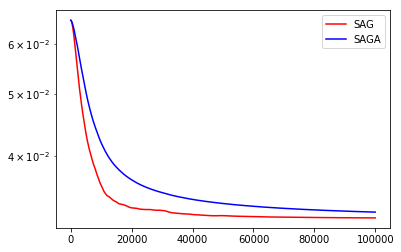

In [171]:
plt.semilogy(np.arange(0, N_ITER, 10), np.linalg.norm(vs - v_sink, axis=1), 'r', label="SAG")
plt.semilogy(np.arange(0, N_ITER, 10), np.linalg.norm(vs1 - v_sink, axis=1), 'b', label="SAGA")
plt.legend()

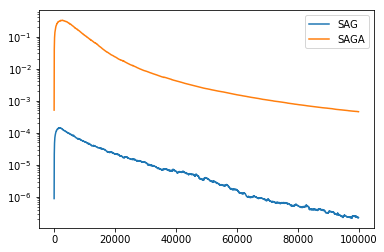

In [170]:
plt.semilogy(np.arange(0, N_ITER, 10), gradh, label="SAG")
plt.semilogy(np.arange(0, N_ITER, 10), gradh1, label="SAGA")
plt.legend()

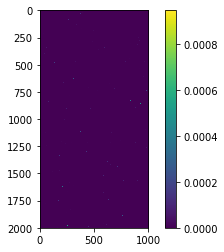

In [172]:
plt.imshow(pi1)
plt.colorbar()

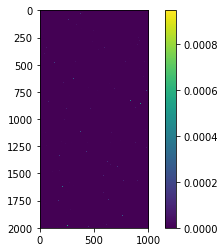

In [173]:
plt.imshow(pi_sink)
plt.colorbar()

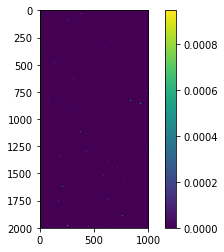

In [174]:
plt.imshow(pi)
plt.colorbar()

In [122]:
true = ot.sinkhorn(a, b, c, eps)
print(np.linalg.norm(ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag') - true)/np.linalg.norm(true))
print(np.linalg.norm(semi_dual_sag(a, b, c, eps, 100000) - true)/np.linalg.norm(true))
print(np.linalg.norm(semi_dual_saga(a, b, c, eps, 100000) - true)/np.linalg.norm(true))

0.3028541228090641
0.0014505157439297942
0.20531367751051852


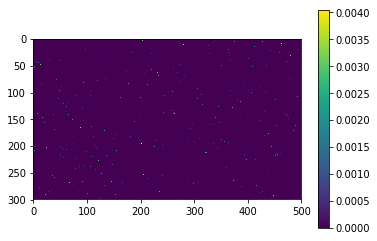

In [123]:
plt.imshow(ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag'))
plt.colorbar()

In [1908]:
%%timeit
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=1000)

39.3 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1909]:
%%timeit
l2 =semi_dual_sag(a, b, c, eps, 1000)

33.5 ms ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [1906]:
%%prun
l = ot.stochastic.solve_semi_dual_entropic(a, b, c, eps, 'sag', numItermax=100000)

         700915 function calls in 4.362 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.586    1.586    4.358    4.358 stochastic.py:87(sag_entropic_transport)
   100000    1.334    0.000    2.285    0.000 stochastic.py:13(coordinate_grad_semi_dual)
   100200    0.524    0.000    0.524    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100000    0.487    0.000    0.487    0.000 {method 'randint' of 'mtrand.RandomState' objects}
   100200    0.202    0.000    0.748    0.000 fromnumeric.py:64(_wrapreduction)
   100100    0.168    0.000    0.951    0.000 fromnumeric.py:1821(sum)
   100100    0.036    0.000    0.036    0.000 {built-in method builtins.isinstance}
   100200    0.021    0.000    0.021    0.000 {method 'items' of 'dict' objects}
        1    0.002    0.002    0.003    0.003 stochastic.py:258(c_transform_entropic)
        1    0.001    0.001    4.362    4.362 {built-in method builtins.exec}
      

In [1907]:
%%prun
l2 =semi_dual_sag(a, b, c, eps, 100000)

         700017 function calls in 3.682 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.514    2.514    3.682    3.682 <ipython-input-1894-9daee9368385>:1(semi_dual_sag)
   200002    0.770    0.000    0.770    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   100002    0.171    0.000    0.589    0.000 fromnumeric.py:64(_wrapreduction)
   100001    0.108    0.000    0.697    0.000 fromnumeric.py:2227(amax)
   100000    0.059    0.000    0.467    0.000 {method 'sum' of 'numpy.ndarray' objects}
   100000    0.036    0.000    0.407    0.000 _methods.py:34(_sum)
   100002    0.019    0.000    0.019    0.000 {method 'items' of 'dict' objects}
        1    0.004    0.004    0.004    0.004 {method 'randint' of 'mtrand.RandomState' objects}
        3    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.zeros}
        1    0.000    0.000    3.682    3.682 {built-in method builtins.exec}
        

In [70]:
import random

In [72]:
%timeit np.random.randint(1000)

4.12 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [74]:
%timeit random.randint(0, 1000 - 1)

3.51 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [75]:
%timeit random.randrange(1000)

2.31 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Semi-discrete optimal transport

### 1D

In [214]:

mu_m = [0.3, 1.2]
mu_std = [0.3, 0.1]
def mu(n):
    p = np.random.random(size=n)>0.4
    return (np.random.normal(loc=mu_m[0], scale=mu_std[0], size=n)*p + 
            np.random.normal(loc=mu_m[1], scale=mu_std[1], size=n)*(1-p))

sample = mu(1000000)
nu_support = np.arange(sample.min(), sample.max(), 0.01)
nu = np.zeros_like(nu_support)
for i in np.random.randint((2/20)*len(nu_support), (18/20)*len(nu_support), size=10):
    nu[i] += np.random.random()
    
nu = nu/nu.sum()

<BarContainer object of 284 artists>

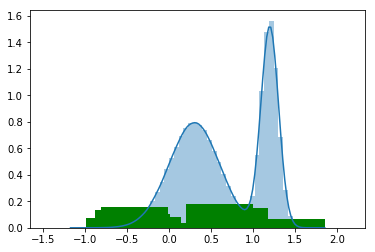

In [215]:
fig, ax = plt.subplots()
sns.distplot(sample, ax=ax)#, bins=100, density=True)
ax.bar(nu_support, nu, color='g')

In [216]:
len(nu_support)

284

In [217]:
N_SOURCE

100

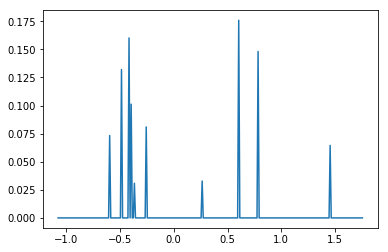

In [218]:
plt.plot(nu_support, nu)

In [219]:
v_tilde = np.zeros(nu.size)
v = v_tilde.copy()
eps=0.1
dist = lambda x, nu: np.abs(nu-x)/10
step = 0.01

for k in tqdm(range(1, 100000)):
    x = mu(1)[0]
    c = dist(x, nu_support)

    tmp = nu * np.exp((1/eps)*(v_tilde - c))
    grad = nu - tmp/tmp.sum()
    
    v_tilde = v_tilde + (step/np.sqrt(k))*grad
    v = (1/k)*v_tilde + (1-(1/k))*v


100%|██████████| 99999/99999 [00:06<00:00, 16294.27it/s]


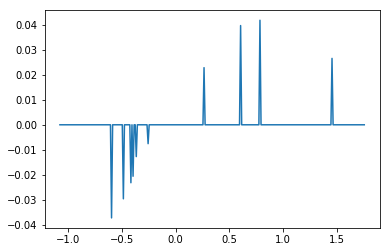

In [220]:
plt.plot(nu_support, -v)

In [221]:
v[np.abs(v)>0]

array([ 0.03727475,  0.02962996,  0.02319764,  0.02059919,  0.01273489,
        0.00756193, -0.02286737, -0.03971489, -0.04184129, -0.02657481])

In [222]:
s = v[np.abs(v)>0]*nu_support[np.abs(v)>0] 
p = np.zeros(len(s)-1)
for i in range(len(s)-1):
    p[i] = (s[i+1] + s[i])/2

In [223]:
all_dists = dist(np.linspace(nu_support.min(), nu_support.max(), 2000).reshape(-1, 1), 
                 nu_support[np.abs(v)>0].reshape(1, -1))
f = np.exp((v[np.abs(v)>0] - all_dists)/eps)
f /= f.sum(axis=1).reshape(-1, 1)

In [224]:
all_dists = dist(np.linspace(nu_support.min(), nu_support.max(), 500).reshape(-1, 1), 
                 nu_support[np.abs(v)>0].reshape(1, -1))
expo = np.exp((v[np.abs(v)>0] - all_dists)/eps)
g_ctrans = - eps* np.log(np.sum(expo*nu[np.abs(v)>0], axis=1))

In [225]:
mil = []
for i in range(len(v[np.abs(v)>0])):
    zer = np.nonzero(f.argmax(axis=1)==i)[0]
    if len(zer):
        mil.append(np.linspace(nu_support.min(), nu_support.max(), 2000)[int(np.mean(zer))])
    else:
        t = i+1
        while not len(np.nonzero(f.argmax(axis=1)==t)[0]):
            t += 1
        mil.append(np.linspace(nu_support.min(), 
                               nu_support.max(), 
                               2000)[np.min(np.nonzero(f.argmax(axis=1)==t)[0])])

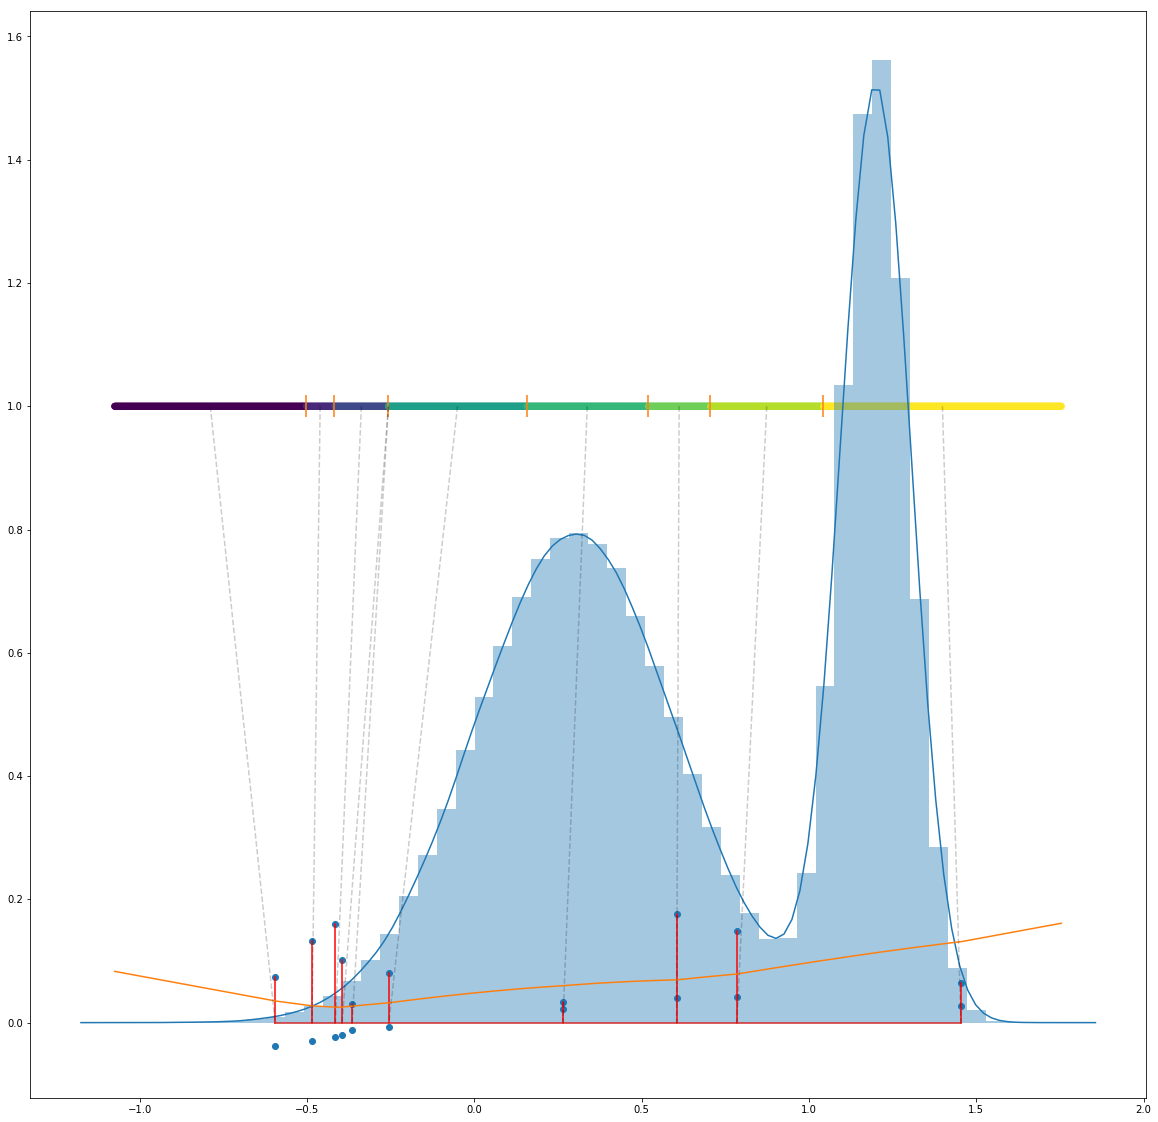

In [226]:
plt.figure(figsize=(20, 20))
sns.distplot(sample)
plt.stem(nu_support[nu!=0], nu[nu!=0], 'r')

plt.scatter(nu_support[np.abs(v)>0],  - v[np.abs(v)>0])
plt.plot(np.linspace(nu_support.min(), nu_support.max(), 500), g_ctrans)
plt.scatter(np.linspace(nu_support.min(), nu_support.max(), 2000), 
            np.zeros(2000)+1, 
            c=f.argmax(axis=1), 
            marker='o')

for n, m in enumerate(mil):
    plt.plot([m, nu_support[np.abs(v)>0][n]], [1, 0], 'k--', alpha=0.2)
    
plt.scatter(np.linspace(nu_support.min(), nu_support.max(), 2000)[np.nonzero(np.diff(f.argmax(axis=1)))[0]], 
            np.ones(len(np.nonzero(np.diff(f.argmax(axis=1)))[0])), 
            marker='|',
            s=500)

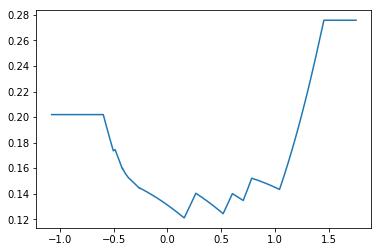

In [228]:
plt.plot(np.linspace(nu_support.min(), nu_support.max(), 2000), f.max(axis=1))


In [198]:
class MultiNormal:
    def __init__(self):
        self.s = np.diag([np.random.randint(1, 10) for i in range(2)])  - np.random.random((2, 2))
        self.s = (self.s + self.s.T)/2
        self.mu = 20*np.random.random(2) + 1

    def __call__(self, size=1):
        return np.random.multivariate_normal(self.mu, self.s, size=size)

In [199]:
def n_gauss(p):
    normals = [MultiNormal() for _ in range(p)]
    pi = np.random.random(size=p)
    pi/=pi.sum()
    
    def mu(n): 
        ran = np.random.random(n)
        
        pred = np.array([m(n) for m in normals])
        print(pred.shape)
        print(pred[ran.reshape(-1, 1) < pi.reshape(1, -1), :].shape)
        return (m1(n)*p.reshape(-1, 1) + m2(n)*(1-p).reshape(-1, 1))
    
    return mu

In [203]:
mmu = n_gauss(3)
mmu(1000).shape

(3, 1000, 2)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1000

In [213]:
mu(10)

array([0.45417453, 0.38459741, 1.20648685, 1.02131505, 1.27735439,
       0.35720618, 0.47446859, 1.27858388, 1.22910065, 0.06355331])

In [210]:
nu_supp = np.random.uniform(d.min(), d.max(), size=(10, 2))
nu = np.random.random(size=len(nu_supp))
nu/=nu.sum()

IndexError: too many indices for array

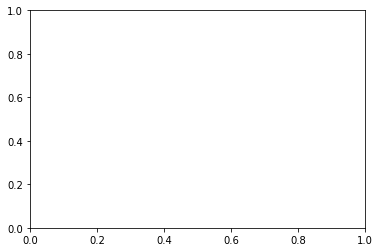

In [212]:
fig, ax = plt.subplots()
d = mu(10000)
ax.scatter(d[:, 0], d[:, 1], s=0.1)
ax.scatter(nu_supp[:, 0], nu_supp[:, 1], s=500*nu)
#ax.scatter(v[:, 0], v[:, 1])

In [1128]:
v_tilde = np.zeros(nu.shape)
v = v_tilde.copy()
eps=0.05
dist = lambda x, nu: np.sqrt(np.sum((nu-x)**2, axis=1))/10
step = 0.01

for k in tqdm(range(1, 1000000)):
    x = mu(1)[0]
    c = dist(x, nu_supp)

    tmp = nu * np.exp((1/eps)*(v_tilde - c))
    grad = nu - tmp/tmp.sum()
    
    v_tilde = v_tilde + (step/np.sqrt(k))*grad
    v = (1/k)*v_tilde + (1-(1/k))*v




  0%|          | 0/999999 [00:00<?, ?it/s]


  0%|          | 148/999999 [00:00<11:16, 1478.95it/s]


  0%|          | 268/999999 [00:00<12:04, 1380.40it/s]


  0%|          | 477/999999 [00:00<10:50, 1536.31it/s]


  0%|          | 714/999999 [00:00<09:42, 1716.61it/s]


  0%|          | 946/999999 [00:00<08:56, 1861.74it/s]


  0%|          | 1150/999999 [00:00<08:42, 1910.38it/s]


  0%|          | 1349/999999 [00:00<08:36, 1932.38it/s]


  0%|          | 1585/999999 [00:00<08:08, 2042.27it/s]


  0%|          | 1812/999999 [00:00<07:54, 2104.92it/s]


  0%|          | 2022/999999 [00:01<08:06, 2052.87it/s]


  0%|          | 2227/999999 [00:01<08:20, 1994.64it/s]


  0%|          | 2430/999999 [00:01<08:17, 2003.22it/s]


  0%|          | 2631/999999 [00:01<08:20, 1993.12it/s]


  0%|          | 2851/999999 [00:01<08:06, 2049.30it/s]


  0%|          | 3099/999999 [00:01<07:41, 2160.66it/s]


  0%|          | 3355/999999 [00:01<07:19, 2266.59it/s]


  0%|          | 3597/999999 

In [1129]:
x, y = np.meshgrid(np.linspace(d.min(), d.max(), 500), np.linspace(d.min(), d.max(), 500))

In [1130]:
all_dists = np.sqrt(np.sum((np.concatenate((x.reshape(-1, 1), 
                            y.reshape(-1, 1)), 
                            axis=1).reshape(-1,1, 2) -  nu_supp)**2, axis=2))

expo = np.exp((v - all_dists)/eps)
g_ctrans = - eps* np.log(np.sum(expo*nu, axis=1))

In [1131]:
f = np.exp((v - all_dists)/eps)
f /= f.sum(axis=1).reshape(-1, 1)

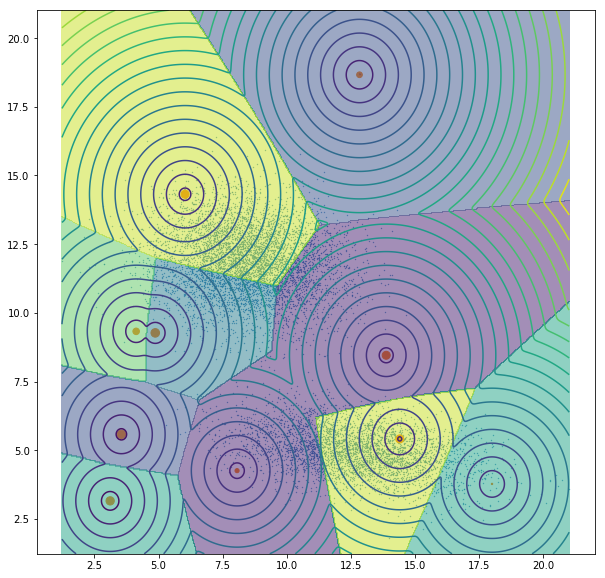

In [1133]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(d[:, 0], d[:, 1], s=0.1)
ax.scatter(nu_supp[:, 0], nu_supp[:, 1], s=500*nu)
ax.contour(x, y, g_ctrans.reshape(500, 500), 20)
ax.contourf(x, y, np.argmax(f, axis=1).reshape(500, 500), alpha=0.5)